# Survival Multiarmed Bandits

## Comparing several algorithms through numerical experiments on the MAGB setting

The survival setting includes a budget $b$. From an initial budget $b_0$, the budget evolves with received rewards.

In [2]:
#parameters
import_smpymab_from_pipy = False
import_smab_from_github = False
import_smab_from_localfolder = False
export_files_from_colab = False

#This option makes the install and import of smpymab package from pipy
if (import_smpymab_from_pipy):
  #install
  !pip install -q SMPyBandits
  
#import
from SMPyBandits.Arms import Bernoulli #, Gaussian, Constant
from SMPyBandits.Policies import Uniform, EmpiricalMeans, UCB, UCBalpha, UCBV, klUCB, Thompson, SoftMix, BayesUCB

#install
#!pip install -q ray

#smab packages on github
if (import_smab_from_github):
    import os
    os.environ['PATH'] += ";C:\\Program Files\\Git\\mingw64\\libexec\\git-core"  
    !pip install git+https://github.com/fsperotto/smab.git
    #!rm -rf '/content/smab'
    #!git clone https://github.com/fsperotto/smab.git
    #import sys
    #sys.path.append('/content/smab')

#smab packages locally
if (import_smab_from_localfolder):
    import sys
    sys.path.append('../smab')


#import smab
#from smab import *
from srl.mab.arms import RandomArm, BernoulliArm
from srl.mab.policies import BasePolicy, RandomPolicy, FixedPolicy, EmpiricalMeansPolicy, EmpiricalSumPolicy, EpsilonGreedyPolicy, SoftMaxPolicy, UCB1Policy, BernKLUCBPolicy, ThompsonPolicy, BayesUCBPolicy, MaRaBPolicy
from srl.mab.policies import BanditGamblerPolicy, BanditGamblerUCBPolicy, AlarmedUCBPolicy, AlarmedBernKLUCBPolicy, AlarmedEpsilonGreedyPolicy, PositiveGamblerUCB
from srl.mab.simulator import SMAB
#from mabsim import mabs
#from mabarms import ExtendedBernoulli
#from mabalgs import SafeUCB, SafeUCBalpha, SafeKLUCB, SafeEpsilonGreedy
#from mabalgs import SafeEpsilonGreedy, SafeUCB, SafeUCBalpha, ClassicEpsilonGreedy, ClassicEpsilonDecreasing, ClassicOptimisticGreedy, SafeKLUCB, PositiveGamblerUCB, GamblerBayesUCB, MaRaB, BanditGambler
#from mabplot import mabplt

#Import Dependencies
import numpy as np
from numpy.random import binomial, randint, uniform, choice, rand, normal
from math import sqrt, log
from scipy.stats import beta
#from scipy.integrate import quad as integral
#from scipy.integrate import fixed_quad as integral
from scipy.integrate import quadrature as integral
import pandas as pd
from numba import jit
from tqdm import tqdm_notebook as tqdm
from collections import Iterable
#from IPython.display import display
import matplotlib.pyplot as plt
#import matplotlib.mlab as mlab
import datetime

%matplotlib inline
#%matplotlib notebook
#import pickle

#This option allows to export the graphics resulting from simulations when running on google colab
if (export_files_from_colab):
  from google.colab import files

#current date
date = datetime.datetime.now().strftime("%Y_%m_%d")

ImportError: cannot import name 'EmpiricalMeansPolicy' from 'srl.mab.policies' (d:\fperotto\sourcecode\srl\src\srl\mab\policies.py)

In [2]:
class GaussianArm(RandomArm):
    """ Gaussian distributed arm."""

    def __str__(self):
        return f"Gaussian Arm ($\\mu={self.mean}, \\sigma^2={self.variance}$)"
    
    def __init__(self, mean, variance):
        """New arm."""
        super().__init__()
        self.variance = variance
        self.mean = mean

    # --- Random samples
    def draw(self, shape=None):
        """ Draw a numpy array of random samples, of a certain shape. If shape is None, return a single sample"""
        return np.random.normal(loc=self.mean, scale=self.variance, size=shape)

## Setting (k-ExtBernoulli-Arms)

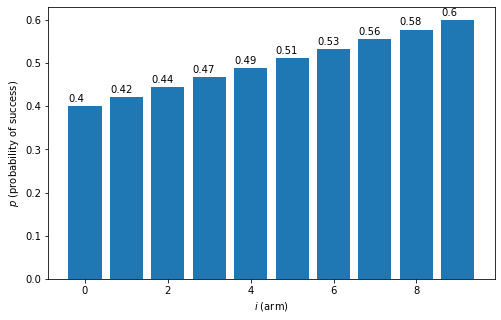

In [3]:
plt.rcParams['figure.figsize'] = (8, 5)

#number of arms and corresponding parameters
k = 10
p_arr = np.linspace(0.4, 0.6, k)

#BERNOULLI
arms = [BernoulliArm(p) for p in p_arr]

#initial budget
b_0 = k #15
omega = k // 2 #5

#domain support for rewards
d = Domain(r_min=-1.0, r_max=+1.0)

#each arm must be tried at least w times at beginning
w=1

#algorithms
algs = [
     FixedPolicy(k, w=w, fixed_i=0, label="Worst Arm"),
     FixedPolicy(k, w=w, fixed_i=k-1, label="Best Arm"),
     RandomPolicy(k, w=w, label="Random Arm"),
     EmpiricalMeansPolicy(k, w=w, label="Empirical Means"),
     EmpiricalSumPolicy(k, w=w, label="Empirical Sum"),
     EpsilonGreedyPolicy(k, w=w, eps=0.1, label="Epsilon-Greedy (0.1)"), 
     AlarmedEpsilonGreedyPolicy(k, w=w, eps=0.1, d=d, b_0=b_0, omega=omega),
     #SoftMaxPolicy(k, w=w),
     BernKLUCBPolicy(k, w=w, label="KL-UCB"),
     AlarmedBernKLUCBPolicy(k, w=w, d=d, b_0=b_0, omega=omega, label="ST-KL-UCB"),
     #UCBalpha(k, alpha=1.0*ampl, lower=minr, amplitude=ampl),
     UCB1Policy(k, w=w, label="UCB"),
     AlarmedUCBPolicy(k, w=w, d=d, b_0=b_0, omega=omega, label="ST-UCB"),
     MaRaBPolicy(k, w=w, label="MaRaB"),
     #UCBV(k, w=w, lower=lower, amplitude=ampl),
     ThompsonPolicy(k, w=w, label="Thompson Sampling"),
     BayesUCBPolicy(k, w=w, label="Bayes-UCB"),
     BanditGamblerPolicy(k, w=w, d=d, b_0=b_0, label="Gambler-Bayes"),  
     BanditGamblerUCBPolicy(k, w=w, d=d, b_0=b_0, label="Gambler-Bayes-UCB"), 
     PositiveGamblerUCB(k, w=w, d=d, b_0=b_0, label="Gambler-Positive")
    ]

algs = [
     FixedPolicy(k, w=w, fixed_i=k-1, label="Best Arm"),
     EmpiricalMeansPolicy(k, w=w, label="Empirical Means"),
     EmpiricalSumPolicy(k, w=w, label="Empirical Sum"),
     EpsilonGreedyPolicy(k, w=w, eps=0.1, label="Epsilon-Greedy (0.1)"), 
     BayesUCBPolicy(k, w=w, label="Bayes-UCB"),
     BanditGamblerUCBPolicy(k, w=w, d=d, b_0=b_0, label="Gambler-Bayes-UCB"), 
    ]

crits = [
    "Survival Episodes Rate", 
    "Survival Time (before ruin or end) (averaged over episodes)", 
    "Survival Time (std dev)", 
    "Cumulative Time on Negative Budget (averaged over episodes)", 
    "Cumulative Time on Negative Budget (std dev)", 
    "Cumulative Negative Budget (averaged over episodes)",
    "Cumulative Negative Budget (std dev)",
    "Cumulative Regret (averaged over episodes)",
    "Cumulative Regret (std dev)"
    ]
labels = ["Worst", "Oracle", "Random", "Empirical-Means", "$\epsilon$-Greedy 01", "$\epsilon$-Greedy 09", "ST-Eps", "SoftMax", "KL-UCB", "ST-KL-UCB", "UCB", "ST-UCB", "MaRaB", "Thompson", "Bayes-UCB", "Bayes-Gambler", "Bayes-UCB-Gambler"]
#labels = ["Empirical-Means", "$\epsilon$-Greedy", "KL-UCB", "UCB", "MaRaB", "Thompson", "Bayes-UCB", "Bayes-Gambler", "Bayes-UCB-Gambler"]
colors = ['r',               'tan',               'm',      'g',   'orange', 'c',        'b',         'k',            'k',                 'c', 'tan', 'pink', 'k', 'm']
styles = ['-',               '--',                '-',      '--', '-',     '--',       '-',           '--',           '-',                 ':', '-.', ':', '-']

#print(p_arr)
plt.ylim=(0.0, 1.0)
plt.bar(range(k), p_arr)
for i,p in enumerate(p_arr):
    plt.text(x=i-0.4, y=p+0.01, s=f"{p:0.2}")
plt.xlabel('$i$ (arm)')
plt.ylabel('$p$ (probability of success)')
plt.show()


## Simulation Bernoulli : short-horizon

 - Several Repetitions 
 - Short Horizon

In [4]:
#time-horizon
h = 1000 #2000

#repetitions
n = 10 #1000

M1 = SMAB(arms, algs, h, b_0, d=d, n=n)
M1.run(tqdm_leave=True)


  0%|          | 0/10 [00:00<?, ?it/s]

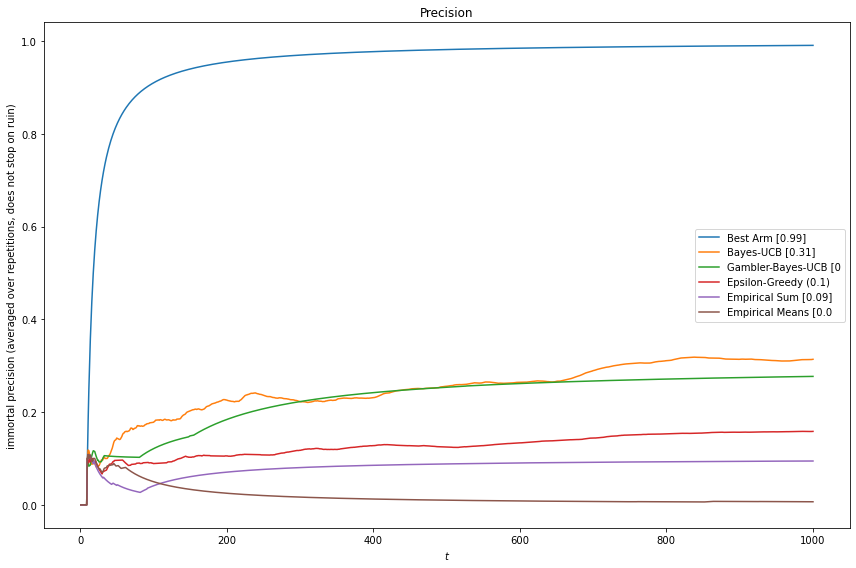

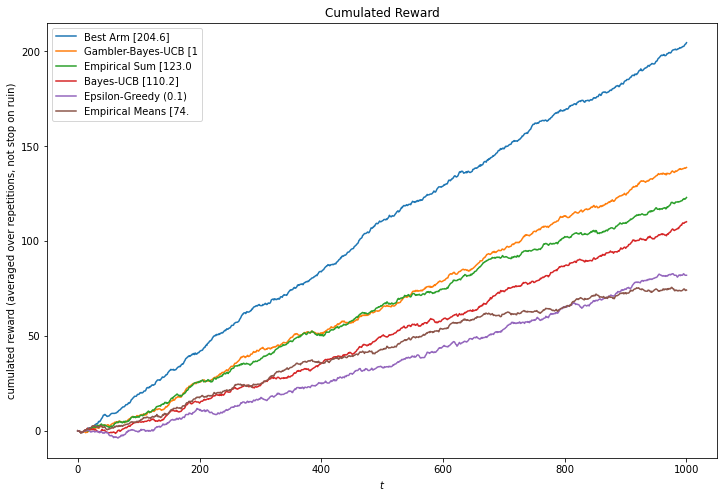

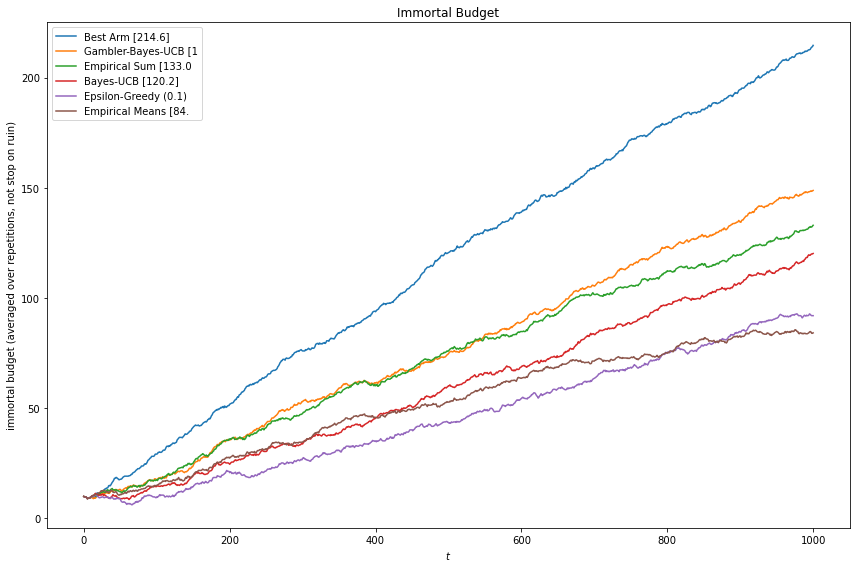

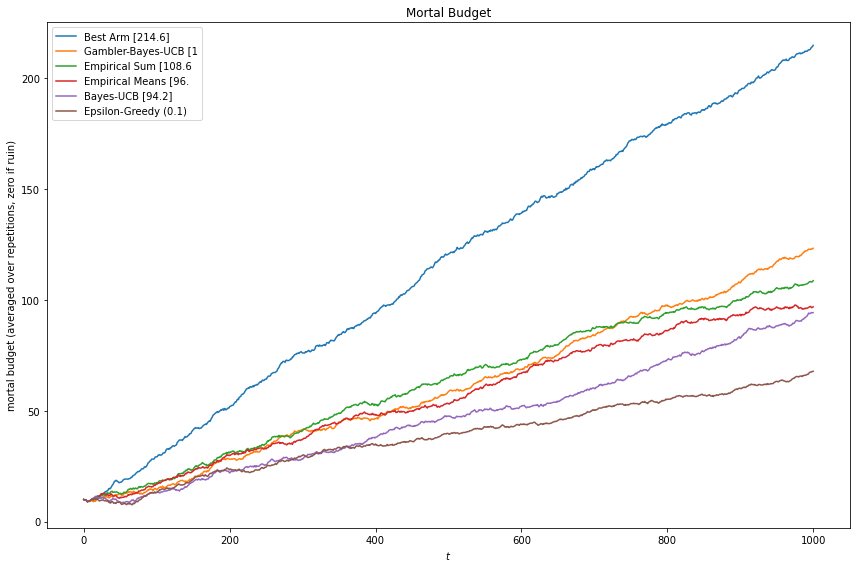

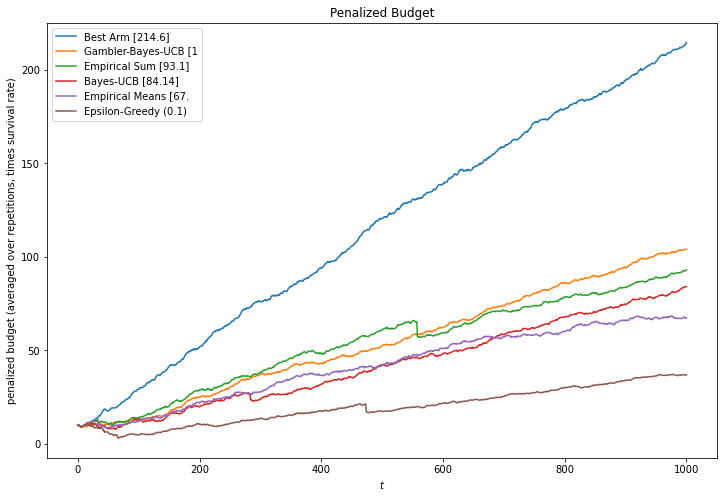

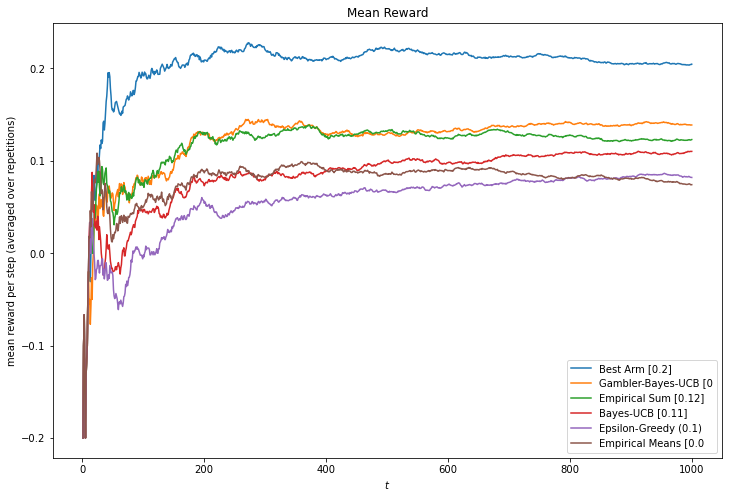

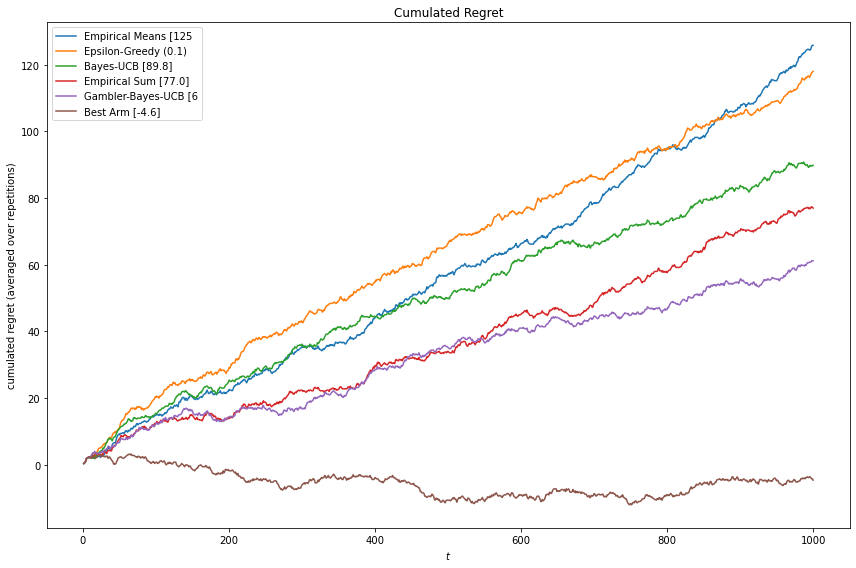

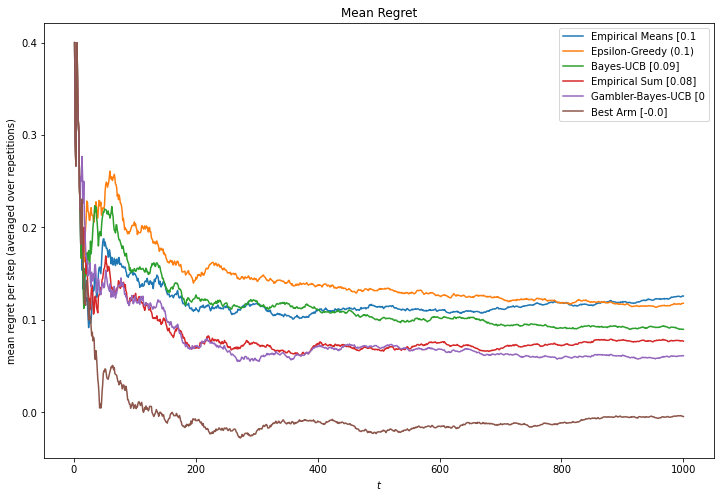

In [6]:
#M1.plot('survival', filename='survival.pdf', figsize=(12,8))
M1.plot('precision', filename='precision.pdf', figsize=(12,8))
M1.plot('sum_reward', figsize=(12,8))
M1.plot('immortal_budget', filename='immortal_budget.pdf', figsize=(12,8))
M1.plot('mortal_budget', filename='mortal_budget.pdf', figsize=(12,8))
M1.plot('penalized_budget', figsize=(12,8))
M1.plot('avg_reward', figsize=(12,8))
M1.plot('sum_regret', filename='sum_regret.pdf', figsize=(12,8))
M1.plot('avg_regret', figsize=(12,8))

#import tikzplotlib
#tikzplotlib.save("test.tex")  #before show

if (export_files_from_colab):
  #files.download(date + '_survival_progression_h' + str(h) + '.pdf')
  files.download('survival.pdf')
  files.download('precision.pdf')
  files.download('immortal_budget.pdf')
  files.download('mortal_budget.pdf')
  files.download('sum_regret.pdf')
  #pass


## Simulation Bernoulli : long-horizon

 - Few Repetitions 
 - Long Horizon

In [ ]:
#time-horizon
h = 10000 

#repetitions
n = 100 #100

M2 = SMAB(arms, algs, h, d=d, n=n, b_0=b_0)
M2.run(tqdm_leave=True)

In [ ]:
M2.plot('survival')
M2.plot('precision')
M2.plot('sum_reward')
M2.plot('immortal_budget')
M2.plot('mortal_budget')
M2.plot('penalized_budget')
M2.plot('avg_reward')
M2.plot('sum_regret')
M2.plot('avg_regret')

if (export_files_from_colab):
  #files.download(date + '_survival_progression_h' + str(h) + '.pdf')
  pass


# Extras

In [7]:
i = np.arange(2, 8)
z = np.divide(np.log(i+1), i)
p = 1 / i
q = 1-p
print(' p :', p)
print(' q :', q)
print(' z :', z)

x = 0
y = 2
px = p*x+1
py = p*y+1
print(beta.median(px, py))

for i in range(len(p)):
  print(i, ':', x, y, beta.median(p[i]*x+1, p[i]*y+1), x+i, y, beta.median(p[i]*x+1+i, p[i]*y+1))


 p : [0.5        0.33333333 0.25       0.2        0.16666667 0.14285714]
 q : [0.5        0.66666667 0.75       0.8        0.83333333 0.85714286]
 z : [0.54930614 0.46209812 0.40235948 0.35835189 0.32431836 0.29706308]
[0.29289322 0.34024604 0.37003948 0.39049317 0.40539644 0.41673548]
0 : 0 2 0.2928932188134525 0 2 0.2928932188134525
1 : 0 2 0.34024604461355284 1 2 0.5545151074423957
2 : 0 2 0.3700394750525634 2 2 0.693052744228799
3 : 0 2 0.39049317289776225 3 2 0.7717969868543402
4 : 0 2 0.40539644249863943 4 2 0.8207613979570209
5 : 0 2 0.4167354802119418 5 2 0.8535168203955527


It can be seen as a random walk over a Markov chain.

In [9]:
from graphviz import Digraph, Source
from google.colab import files

g = Digraph('G', filename='walk')
g.attr(rankdir='LR', concentrate='false', margin='0')

#g.attr('node', shape='circle')

g.node('0')
g.node('1')
g.node('2')
g.node('3', label='...', shape='plaintext')
g.node('4', label='b-1')
g.node('5', label='b')
g.node('6', label='b+1')
g.node('7', label='...', shape='plaintext')
g.edge('1', '0', label='q')
g.edge('2', '1', label='q')
g.edge('3', '2', label='q')
g.edge('4', '3', label='q')
g.edge('5', '4', label='q')
g.edge('6', '5', label='q')
g.edge('7', '6', label='q')
g.edge('0', '0', label='1')
g.edge('0', '1', label='', style='invis')
g.edge('1', '2', label='p')
g.edge('2', '3', label='p')
g.edge('3', '4', label='p')
g.edge('4', '5', label='p')
g.edge('5', '6', label='p')
g.edge('6', '7', label='p')

g.render()

#s = Source(g, filename="walk", format="pdf")
#s.view()

#files.download('walk.pdf')

g


ModuleNotFoundError: No module named 'graphviz'